### The implementation is tailored for running things in a distributed and scalable way. With minimal changes the code can therefore, be executed on a massively large dataset.

In [1]:
import sys

if sys.version_info.major != 3:
    raise EnvironmentError("The code has only been tested on Python version 3")
if sys.version_info.minor < 7:
    raise EnvironmentError("The code has only been tested on Python version 3.7+")

### Pre-requisite Libraries

In [2]:
! pip install matplotlib==3.4.3
! pip install networkx==2.6.3
! pip install pandas==1.4.1
! pip install pyspark==3.2.0
! pip install graphframes==0.6
! pip install leidenalg==0.9.1

In [3]:
import os
import shutil
from io import StringIO
from datetime import datetime, timedelta

import igraph as ig
import networkx as nx
import pandas as pd
import leidenalg as la
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from graphframes import GraphFrame

In [4]:
DATA_FOLDER = os.path.join(".", "data")

In [20]:
config = [("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")]
spark = SparkSession.builder.appName("fastman").config(conf=SparkConf().setAll(config)).getOrCreate()

In [6]:
# Prepare input data

location_staging = os.path.join(DATA_FOLDER, "staging")

transactions = StringIO(
"""
id,source,target,timestamp,amount
1,A,B,2020-01-01 12:35:01,100
2,B,D,2020-01-02 22:40:05,800
3,A,B,2020-01-03 01:35:49,50
4,B,C,2020-01-04 09:10:12,150
5,D,E,2020-01-05 08:01:10,900
6,E,A,2020-01-05 22:15:12,600
7,A,K,2020-01-06 00:55:32,2500
8,D,L,2020-01-08 11:15:26,3000
9,E,L,2020-01-09 09:30:40,10
10,L,M,2020-01-10 13:10:55,90
"""
)
transactions = pd.read_csv(transactions, sep=",")
transactions.loc[:, "transaction_timestamp"] = pd.to_datetime(transactions.loc[:, "timestamp"])
transactions.loc[:, "transaction_date"] = transactions.loc[:, "transaction_timestamp"].dt.date
transactions.loc[:, "transaction_timestamp"] = (
    transactions.loc[:, "transaction_timestamp"].values.astype(int) // 10**9
)
del transactions["timestamp"]
transactions.to_parquet(location_staging)

location_transactions = os.path.join(DATA_FOLDER, "transactions")
staged = spark.read.parquet(location_staging)
(
    staged.repartition("transaction_date")
    .write.partitionBy("transaction_date")
    .mode("overwrite")
    .parquet(location_transactions)
)

In [7]:
data = spark.read.parquet(location_transactions)
data.sort("id").show()

+---+------+------+------+---------------------+----------------+
| id|source|target|amount|transaction_timestamp|transaction_date|
+---+------+------+------+---------------------+----------------+
|  1|     A|     B|   100|           1577882101|      2020-01-01|
|  2|     B|     D|   800|           1578004805|      2020-01-02|
|  3|     A|     B|    50|           1578015349|      2020-01-03|
|  4|     B|     C|   150|           1578129012|      2020-01-04|
|  5|     D|     E|   900|           1578211270|      2020-01-05|
|  6|     E|     A|   600|           1578262512|      2020-01-05|
|  7|     A|     K|  2500|           1578272132|      2020-01-06|
|  8|     D|     L|  3000|           1578482126|      2020-01-08|
|  9|     E|     L|    10|           1578562240|      2020-01-09|
| 10|     L|     M|    90|           1578661855|      2020-01-10|
+---+------+------+------+---------------------+----------------+



In [8]:
# FaSTMⱯN Parameters

# This is a dummy value in days --> Change this
WINDOW = 3
# This is also dummy
MIN_EDGE_WEIGHT = 0.5

In [9]:
def rename_columns(dataframe, names):
    for name, new_name in names.items():
        dataframe = dataframe.withColumnRenamed(name, new_name)
    return dataframe


def max_timestamp(dt):
    year, month, date = dt.split("-")
    return (datetime(int(year), int(month), int(date)) + timedelta(days=1)).timestamp()

## Temporal Graph of Sequential Transactions

### Iterative Joins

In [10]:
location_joins = os.path.join(DATA_FOLDER, "joins")
shutil.rmtree(location_joins, ignore_errors=True)

left_columns = {x: f"{x}_left" for x in data.columns}
dates = data.select("transaction_date").distinct().toPandas()
dates = sorted([str(x) for x in dates["transaction_date"].tolist()])
for transaction_date in dates:
    start_index = dates.index(transaction_date)
    end_index = start_index + WINDOW + 1
    right_dates = dates[start_index:end_index]
    end_date_max = str(pd.to_datetime(transaction_date).date() + timedelta(days=WINDOW))
    right_dates = [x for x in right_dates if x <= end_date_max]
    right = spark.read.option("basePath", location_transactions).parquet(
        *[f"{location_transactions}{os.sep}transaction_date={x}" for x in right_dates]
    )
    left = rename_columns(right.where(right.transaction_timestamp < max_timestamp(transaction_date)), left_columns)
    join = left.join(right, left.target_left == right.source, "inner")
    join = join.withColumn("delta", join.transaction_timestamp - join.transaction_timestamp_left)
    join = join.where(join.delta > 0)
    join.write.parquet(f"{location_joins}/staging_date={transaction_date}", mode="overwrite")

In [11]:
joins = spark.read.parquet(location_joins)

### Nodes and Edges Creation

In [12]:
node_columns = [
    "id",
    "source",
    "target",
    "transaction_date",
    "transaction_timestamp",
    "amount",
]

nodes_1 = (
    (
        joins.select(
            sf.col("id_left").alias("id"),
            sf.col("source_left").alias("source"),
            sf.col("target_left").alias("target"),
            sf.col("transaction_timestamp_left").alias("transaction_timestamp"),
            sf.col("amount_left").alias("amount"),
            sf.col("transaction_date_left").alias("transaction_date"),
        )
    )
    .select(*node_columns)
    .drop_duplicates(subset=["id"])
)
nodes_2 = joins.select(*node_columns).drop_duplicates(subset=["id"])
nodes = nodes_1.union(nodes_2).drop_duplicates(subset=["id"])

edges = joins.select(
    sf.col("id_left").alias("src"),
    sf.col("id").alias("dst"),
    sf.col("transaction_date_left").alias("src_date"),
    sf.col("transaction_date").alias("dst_date"),
)

nodes_location = os.path.join(DATA_FOLDER, "nodes")
edges_location = os.path.join(DATA_FOLDER, "edges")

nodes = nodes.repartition("transaction_date")
nodes.write.partitionBy("transaction_date").mode("overwrite").parquet(nodes_location)

partition_by = ["src_date", "dst_date"]
edges.repartition(*partition_by).write.partitionBy(*partition_by).mode("overwrite").parquet(edges_location)

nodes = spark.read.parquet(nodes_location)
edges = spark.read.parquet(edges_location)

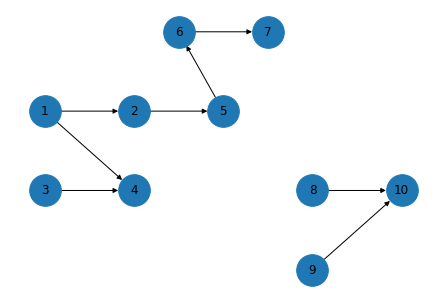

In [13]:
# Plot the temporal graph

edges_temporal = edges.toPandas().sort_values(["dst", "src"]).reset_index(drop=True)
temporal_graph = nx.convert_matrix.from_pandas_edgelist(
    edges_temporal, source="src", target="dst", create_using=nx.DiGraph
)
pos = {
    1: [0, 2],
    2: [2, 2],
    3: [0, 1],
    4: [2, 1],
    5: [4, 2],
    6: [3, 3],
    7: [5, 3],
    8: [6, 1],
    9: [6, 0],
    10: [8, 1]
}
nx.draw(temporal_graph, pos=pos, node_size=1000, with_labels=True)

## 2nd Order Graph of Sequential Transactions

In [14]:
location_co_occurrences = os.path.join(DATA_FOLDER, "co-occurrences")
shutil.rmtree(location_co_occurrences, ignore_errors=True)

# This part can be modified to create higher order graphs
pattern = "(x1) - [e1] -> (x2)"
src_second_order = sf.concat(sf.col("x1.source"), sf.lit(">>"), sf.col("x1.target")).alias("src")
dst_second_order = sf.concat(sf.col("x2.source"), sf.lit(">>"), sf.col("x2.target")).alias("dst")
dates = edges.groupby(["src_date", "dst_date"]).agg(sf.first("src_date")).toPandas()
dates = [(row["src_date"], row["dst_date"]) for index, row in dates.iterrows()]
dst_dates = sorted(set([x for _, x in dates]))
for dst_date in dst_dates:
    edges_dates = [(x, y) for x, y in dates if y == dst_date]
    nodes_dates = sorted(set([x for y in edges_dates for x in y]))
    edges_locations = [f"{edges_location}/src_date={x}/dst_date={y}" for x, y in edges_dates]
    nodes_locations = [f"{nodes_location}/transaction_date={x}" for x in nodes_dates]
    graph = GraphFrame(spark.read.parquet(*nodes_locations), spark.read.parquet(*edges_locations))
    (
        graph.find(pattern)
        .select(
            src_second_order,
            dst_second_order,
            sf.col("x1.transaction_timestamp").alias("ts"),
            sf.col("x2.id").alias("right"),
        )
        .groupby(["src", "right"])
        .agg(sf.first("dst").alias("dst"), sf.max("ts").alias("moment"))
        # NOTE: The weights will be calculated per distinct `moment`
        # This means, for instance [t1]A>>B ---> [t3]A>>B ---> [t4]B>>C is counted once
        .select("src", "dst", "moment")
        .drop_duplicates()
    ).write.mode("overwrite").parquet(f"{location_co_occurrences}/date={dst_date}")

co_occurrences = spark.read.parquet(location_co_occurrences)

location_counts = os.path.join(DATA_FOLDER, "co-occurrences-counts")
(co_occurrences.drop_duplicates().groupby(["src", "dst"]).count().write.mode("overwrite").parquet(location_counts))

counts_data = spark.read.parquet(location_counts)
src_perspective = counts_data.groupby("src").agg(sf.sum("count").alias("src_total"))
dst_perspective = counts_data.groupby("dst").agg(sf.sum("count").alias("dst_total"))

location_second_order = os.path.join(DATA_FOLDER, "second-order")
weights = (
    counts_data.join(src_perspective, "src", "left")
    .withColumn("weight_src", (sf.col("count") / sf.col("src_total")))
    .select("src", "dst", "count", "weight_src")
    .join(dst_perspective, "dst", "left")
    .withColumn("weight_dst", (sf.col("count") / sf.col("dst_total")))
    .select("src", "dst", "weight_src", "weight_dst")
).select("src", "dst", sf.greatest(sf.col("weight_src"), sf.col("weight_dst")).alias("weight"))
weights.write.mode("overwrite").parquet(location_second_order)

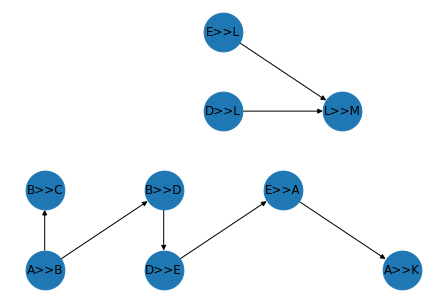

In [15]:
# Plot the 2nd order graph

# NOTE: The weights will be calculated per distinct `moment`
# This means, for instance [t1]A>>B ---> [t3]A>>B ---> [t4]B>>C is counted once
edges_second_order = co_occurrences.toPandas().sort_values(["src", "dst"]).reset_index(drop=True)
second_order_graph = nx.convert_matrix.from_pandas_edgelist(
    edges_second_order, source="src", target="dst", create_using=nx.DiGraph
)
pos = {
    "A>>B": [0, 1],
    "B>>C": [0, 2],
    "B>>D": [2, 2],
    "D>>E": [2, 1],
    "E>>A": [4, 2],
    "A>>K": [6, 1],
    "E>>L": [3, 4],
    "D>>L": [3, 3],
    "L>>M": [5, 3],
}
nx.draw(second_order_graph, pos=pos, node_size=1500, with_labels=True)

### Apply weights to the temporal graph

In [16]:
location_edges_staging = os.path.join(DATA_FOLDER, "edges-staging")
shutil.rmtree(location_edges_staging, ignore_errors=True)

weights = spark.read.parquet(location_second_order)
# Remove very weak edges
weights_filtered = weights.where(sf.col("weight") >= MIN_EDGE_WEIGHT)
src_dates = sorted(set([x for x, _ in dates]))
all_nodes_dates = sorted(set([x for y in dates for x in y]))
columns = [sf.col("src_id").alias("src"), sf.col("dst_id").alias("dst"), "weight", "src_date", "dst_date"]
for src_date in src_dates:
    src_edges = spark.read.option("basePath", edges_location).parquet(f"{edges_location}/src_date={src_date}")
    nodes_dates = [x.date() for x in pd.date_range(src_date, freq="d", periods=WINDOW + 1)]
    nodes_dates = [str(x) for x in set(nodes_dates).intersection(all_nodes_dates)]
    nodes_locations = [f"{nodes_location}/transaction_date={x}" for x in nodes_dates]
    graph = GraphFrame(spark.read.option("basePath", nodes_location).parquet(*nodes_locations), src_edges)
    (
        graph.find(pattern)
        .select(
            sf.col("x1.id").alias("src_id"),
            sf.col("x2.id").alias("dst_id"),
            sf.col("x1.transaction_date").alias("src_date"),
            sf.col("x2.transaction_date").alias("dst_date"),
            src_second_order,
            dst_second_order,
        )
        .join(
            weights_filtered,
            ["src", "dst"],
            "inner",
        )
        .drop("src", "dst")
        .select(*columns)
    ).write.mode("overwrite").parquet(f"{location_edges_staging}/staging_date={src_date}")

edges_staged = spark.read.parquet(location_edges_staging).drop("staging_date")
nodes = spark.read.parquet(nodes_location)

edges_filtered_location = os.path.join(DATA_FOLDER, "edges-filtered")
nodes_filtered_location = os.path.join(DATA_FOLDER, "nodes-filtered")

partition_by = ["src_date", "dst_date"]
edges_staged.repartition(*partition_by).write.partitionBy(*partition_by).mode("overwrite").parquet(
    edges_filtered_location
)
edges_filtered = spark.read.parquet(edges_filtered_location)

nodes_1 = edges_filtered.select(sf.col("src").alias("id")).drop_duplicates(subset=["id"])
nodes_2 = edges_filtered.select(sf.col("dst").alias("id")).drop_duplicates(subset=["id"])
node_ids = nodes_1.union(nodes_2).drop_duplicates(subset=["id"])

partition = "transaction_date"
node_ids.join(nodes, "id", "left").repartition(partition).write.partitionBy(partition).mode("overwrite").parquet(
    nodes_filtered_location
)

nodes = spark.read.parquet(nodes_filtered_location)
edges = spark.read.parquet(edges_filtered_location)

## Community Detection on a single Window

In [17]:
window_start_date = transactions.transaction_date.min()
window = pd.date_range(window_start_date, freq="d", periods=WINDOW)
window = [f"{edges_filtered_location}/src_date={x.date()}" for x in window]
window_data = spark.read.option("basePath", edges_filtered_location).parquet(*window).toPandas()

graph = ig.Graph.DataFrame(window_data, use_vids=False, directed=True)
communities = la.find_partition(graph, la.ModularityVertexPartition, weights="weight", n_iterations=5)
communities_output = graph.get_vertex_dataframe()
communities_output.loc[:, "label"] = communities.membership
communities_output.sort_values("label")

,name,label
vertex ID,,
1,4,0
4,3,0
2,2,1
3,5,1
0,1,2


## Community Detection on the complete dataset

In [18]:
complete = spark.read.parquet(edges_filtered_location).toPandas()

graph = ig.Graph.DataFrame(complete, use_vids=False, directed=True)
communities = la.find_partition(graph, la.ModularityVertexPartition, weights="weight", n_iterations=5)
communities_output = graph.get_vertex_dataframe()
communities_output.loc[:, "label"] = communities.membership

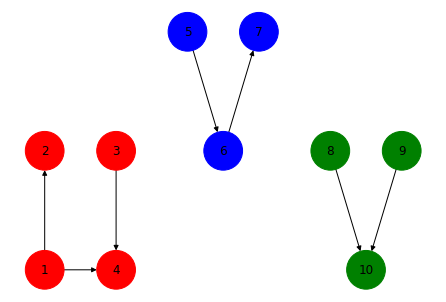

In [19]:
# Plot the communities

communities_graph = nx.DiGraph()
for key, group in communities_output.groupby("label"):
    nodes = group["name"].tolist()
    communities_graph.add_edges_from([sorted(x) for x in zip(nodes[1:], nodes)])

color_map = ["red", "red", "red", "red", "green", "green", "green", "blue", "blue", "blue"]
pos = {
    1: [0, 1],
    2: [0, 1.5],
    3: [2, 1.5],
    4: [2, 1],
    5: [4, 2],
    6: [5, 1.5],
    7: [6, 2],
    8: [8, 1.5],
    9: [10, 1.5],
    10: [9, 1],
}
nx.draw(communities_graph, pos=pos, node_size=1500, node_color=color_map, with_labels=True)

## [Undisclosed] Risk-based scoring of the communities